In [1]:
# 多GPU训练
''' 
数据并行方法

最后⼀种⽅法，跨多个GPU对数据进⾏拆分。这种⽅式下，所有GPU尽管有不同的观测结果，但是执⾏着相
同类型的⼯作。在完成每个⼩批量数据的训练之后，梯度在GPU上聚合。这种⽅法最简单，并可以应⽤于任
何情况，同步只需要在每个⼩批量数据处理之后进⾏。也就是说，当其他梯度参数仍在计算时，完成计算的
梯度参数就可以开始交换。⽽且，GPU的数量越多，⼩批量包含的数据量就越⼤，从⽽就能提⾼训练效率。但
是，添加更多的GPU并不能让我们训练更⼤的模型。
--------------------------------------------------------------------------------------
据并⾏性
假设⼀台机器有k个GPU。给定需要训练的模型，虽然每个GPU上的参数值都是相同且同步的，但是每个GPU都
将独⽴地维护⼀组完整的模型参数。例如，图12.5.3演⽰了在k = 2时基于数据并⾏⽅法训练模型。

⼀般来说，k个GPU并⾏训练过程如下：
• 在任何⼀次训练迭代中，给定的随机的⼩批量样本都将被分成k个部分，并均匀地分配到GPU上。
• 每个GPU根据分配给它的⼩批量⼦集，计算模型参数的损失和梯度。
• 将k个GPU中的局部梯度聚合，以获得当前⼩批量的随机梯度。
• 聚合梯度被重新分发到每个GPU中。
• 每个GPU使⽤这个⼩批量随机梯度，来更新它所维护的完整的模型参数集。

在实践中请注意，当在k个GPU上训练时，需要扩⼤⼩批量的⼤⼩为k的倍数，这样每个GPU都有相同的⼯作
量，就像只在单个GPU上训练⼀样。因此，在16-GPU服务器上可以显著地增加⼩批量数据量的⼤⼩，同时可
能还需要相应地提⾼学习率。还请注意，7.5节中的批量规范化也需要调整，例如，为每个GPU保留单独的批
量规范化参数。
下⾯我们将使⽤⼀个简单⽹络来演⽰多GPU训练。
'''
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
#  简单⽹络
# 我们使⽤ 6.6节中介绍的（稍加修改的）LeNet，从零开始定义它，从⽽详细说明参数交换和同步
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]
# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat
# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [3]:
# 数据同步
''' 
对于⾼效的多GPU训练，我们需要两个基本操作。⾸先，我们需要向多个设备分发参数并附加梯度
（get_params）。如果没有参数，就不可能在GPU上评估⽹络。第⼆，需要跨多个设备对参数求和，也就
是说，需要⼀个 allreduce 函数。
'''
def get_params(params, device): # 梯度
    new_params = [p.to(device) for p in params] # 向多个设备分发参数
    for p in new_params:
        p.requires_grad_()
    return new_params

In [4]:
# 通过将模型参数复制到⼀个GPU
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度: None


In [5]:
''' 
由于还没有进⾏任何计算，因此权重参数的梯度仍然为零。假设现在有⼀个向量分布在多个GPU上，下⾯
的allreduce函数将所有向量相加，并将结果⼴播给所有GPU。请注意，我们需要将数据复制到累积结果的
设备，才能使函数正常⼯作  reduce 归纳为,整合
'''
def allreduce(data): # 将所有向量相加到累积结果的设备,即 data[0].device
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device) # 将数据复制到累积结果的设备进行累加
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device) # 将结果广播给所有GPU

In [6]:
# 通过在不同设备上创建具有不同值的向量并聚合它们
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


In [8]:
# 数据分发
''' 
我们需要⼀个简单的⼯具函数，将⼀个⼩批量数据均匀地分布在多个GPU上。例如，有两个GPU时，我们希
望每个GPU可以复制⼀半的数据。因为深度学习框架的内置函数编写代码更⽅便、更简洁，所以在4 × 5矩阵
上使⽤它进⾏尝试。

parallel 平行线,对比 scatter 分散 
'''
data = torch.arange(20).reshape(4, 5) # arange 矩阵
# devices = [torch.device('cuda:0'), torch.device('cuda:1')]
devices = [torch.device('cuda:0')]
split = nn.parallel.scatter(data, devices) # 将张量切片成大致相等的块并分布在给定的 GPU 上
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0)]
output: (tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'),)


In [9]:
# 为了⽅便以后复⽤，我们定义了可以同时拆分数据和标签的split_batch函数
''' devices = [torch.device('cuda:0'), torch.device('cuda:1')] '''
#@save
def split_batch(X, y, devices): # 批量拆分
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0] # 断言X,y的行数是否相等
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices)) # 均分数据到相应设备

In [10]:
# 训练
''' 
现在我们可以在⼀个⼩批量上实现多GPU训练。在多个GPU之间同步数据将使⽤刚才讨论的辅助函
数allreduce和split_and_load。我们不需要编写任何特定的代码来实现并⾏性。因为计算图在⼩批
量内的设备之间没有任何依赖关系，因此它是“⾃动地”并⾏执⾏
'''
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices) # 将X,y拆分到多个设备上
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad(): # 在该模块下，所有计算得出的tensor的requires_grad都自动设置为False
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))]) # 参数整合
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量 随机梯度下降

In [11]:
''' 
现在，我们可以定义训练函数。与前⼏章中略有不同：训练函数需要分配GPU并将所有模型参数复制到所有
设备。显然，每个⼩批量都是使⽤ train_batch 函数来处理多个GPU。我们只在⼀个GPU上计算模型的精确
度，⽽让其他GPU保持空闲，尽管这是相对低效的，但是使⽤⽅便且代码简洁
'''
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)] # 所有GPU,本机只有一个
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr) # 在多个GPU上进行批量训练
            torch.cuda.synchronize() # 同步,等待 CUDA 设备上所有流中的所有内核完成
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

测试精度：0.83，2.1秒/轮，在[device(type='cuda', index=0)]


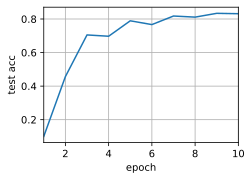

In [12]:
# 让我们看看在单个GPU上运⾏效果得有多好。⾸先使⽤的批量⼤⼩是256，学习率是0.2。
train(num_gpus=1, batch_size=256, lr=0.2)

In [ ]:
''' 
保持批量⼤⼩和学习率不变，并增加为2个GPU，我们可以看到测试精度与之前的实验基本相同。不同的GPU个
数在算法寻优⽅⾯是相同的。不幸的是，这⾥没有任何有意义的加速：模型实在太⼩了；⽽且数据集也太⼩
了，在这个数据集中，我们实现的多GPU训练的简单⽅法受到了巨⼤的Python开销的影响。在未来，我们将
遇到更复杂的模型和更复杂的并⾏化⽅法。尽管如此，让我们看看Fashion-MNIST数据集上会发⽣什么

train(num_gpus=2, batch_size=256, lr=0.2)

测试精度：0.83，2.7秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]
--------------------------------------------------------------------------------------
⼩结
• 有多种⽅法可以在多个GPU上拆分深度⽹络的训练。拆分可以在层之间、跨层或跨数据上实现。前两者
需要对数据传输过程进⾏严格编排，⽽最后⼀种则是最简单的策略。
• 数据并⾏训练本⾝是不复杂的，它通过增加有效的⼩批量数据量的⼤⼩提⾼了训练效率。
• 在数据并⾏中，数据需要跨多个GPU拆分，其中每个GPU执⾏⾃⼰的前向传播和反向传播，随后所有的
梯度被聚合为⼀，之后聚合结果向所有的GPU⼴播。
• ⼩批量数据量更⼤时，学习率也需要稍微提⾼⼀些
'''
